In [482]:
# Para que las funciones se actualicen sin tener que refrescar el kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [483]:
# Funciones propias
from utils_limpieza import * 

In [484]:
import pandas as pd
import json
from os.path import exists
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [485]:
# Cargar datos
path = '../data/raw/tp2_muestra_diplodatos_ventas_omega_modelo_2023.csv'
ventas = pd.read_csv(path)


C:\Users\Patricio\AppData\Local\Temp\ipykernel_4688\3921706967.py:3: DtypeWarning: Columns (10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ventas = pd.read_csv(path)


## Hacemos la limpieza sugerida al principio del TP2
- [x] Eliminar las variables en `cols_dropear` (Paso 1).
- [x] Renombrar a 'Otros' las subcategorías que no tengan `MODELO` (Paso 2).
- [x] Se eliminan los registros en 'Otros'. Previamente se almacenan en un dataset aparte.

In [486]:
print(f'El df original tiene {ventas.shape[0]} registros y {ventas.shape[1]} variables.\n')

# Paso 1
cols_dropear = ['INSCRIPCION', 'CATEGORIA', 'DESCRIPCION_CATEGORIA', 'CATEGORIA (Ajustado)', 'NOMBRE']
ventas_renamed = limpiar_basic(ventas, cols_drop=cols_dropear)
print(f'Luego del paso 1 se tiran {len(cols_dropear)} variables, quedando {ventas_renamed.shape[1]} variables.\n')

# Paso 2
# ventas_renamed['SUB-CATEGORIA'].nunique() # antes del paso 2
ventas_renamed = renombrar_elementos(ventas_renamed, 
                                     columna='SUB-CATEGORIA', 
                                     fill_otros='Otros')

scu_vr = ventas_renamed['SUB-CATEGORIA'].nunique()
scu_ot = ventas_renamed['SUB-CATEGORIA'].nunique() - scu_vr + 1
print(f'Luego del paso 2 quedan {scu_vr} subcategorías únicas.')
print(f'Las {scu_ot} subcategorías únicas que no tenían ningún vendedor modelo fueron agrupadas en "Otros".')
print(f'Las {scu_vr-1} subcategorías que sí tienen ventas_categ modelo son:')

ventas_renamed.groupby(by=['SUB-CATEGORIA'])['MODELO'].sum().sort_values(ascending=False)[:12]

El df original tiene 435489 registros y 19 variables.

Luego del paso 1 se tiran 5 variables, quedando 14 variables.

Luego del paso 2 quedan 13 subcategorías únicas.
Las 1 subcategorías únicas que no tenían ningún vendedor modelo fueron agrupadas en "Otros".
Las 12 subcategorías que sí tienen ventas_categ modelo son:


SUB-CATEGORIA
Venta de Artículos, productos, accesorios, etc de diversos materiales      1902
Venta de Combustibles (Incluye tmb gas, carbón, leña, etc)                  951
Venta de Productos Alimenticios, Bebidas, Lácteos y afines                  586
Venta de Productos farmacéuticos, de perfumería, cosméticos y similares     420
Venta de Combustibles Ley 23966 (Incluye tmb gas, carbón, leña, etc)        394
Venta en Comisión, Consignación o Intermediación de Productos Varios        336
Cigarrillos, tabacos y afines                                               282
Supermercados, Hipermercados, Kioscos y afines                              156
Venta de Combustibles para reventa (Incluye tmb gas, carbón, leña, etc)     131
Venta de Autos, Camionetas, Motos, y Afines                                 126
Venta de Semillas, Fertilizantes, Granos y afines                            84
Instalación, Mantenimiento, Reparación, etc de productos varios               6
Name: MODELO, dtype: int64

In [487]:
#Eliminación de registros en "Otros" y almacenamiento en un dataset aparte

ventas_otros = ventas_renamed[ventas_renamed['SUB-CATEGORIA'] == 'Otros'].copy()
ventas_otros.to_csv('../data/interim/tp2_ventas_otros.csv')

ventas_renamed = ventas_renamed[ventas_renamed['SUB-CATEGORIA'] != 'Otros'].copy()

## Análisis de datos faltantes
- [x] Chequear presencia de datos faltantes
- [x] Analizar su correlación
- [x] Imputar de valores faltantes: `CM` y `Trat_Dif` con 'No'.

Faltan datos en las mismas variables que antes. Imputo los complementos en `CM` y `Trat_Dif` para dejarlas listas. Luego de eso, se cumple lo que ya habíamos visto en el tp1.

In [488]:
ventas_renamed.columns

Index(['ID_VENDEDOR', 'AÑO', 'MES', 'DEPOSITO', 'TOTAL_VENTAS',
       'PORCENTAJE_COMISION_EMPRESA', 'COMISION_EMPRESA', 'TRATAMIENTO_FISCAL',
       'DESC_TRATAMIENTO_FISCAL', 'TRATAMIENTO_DIFERNCIAL', 'CM04',
       'SUB-CATEGORIA', 'OMEGA', 'MODELO'],
      dtype='object')

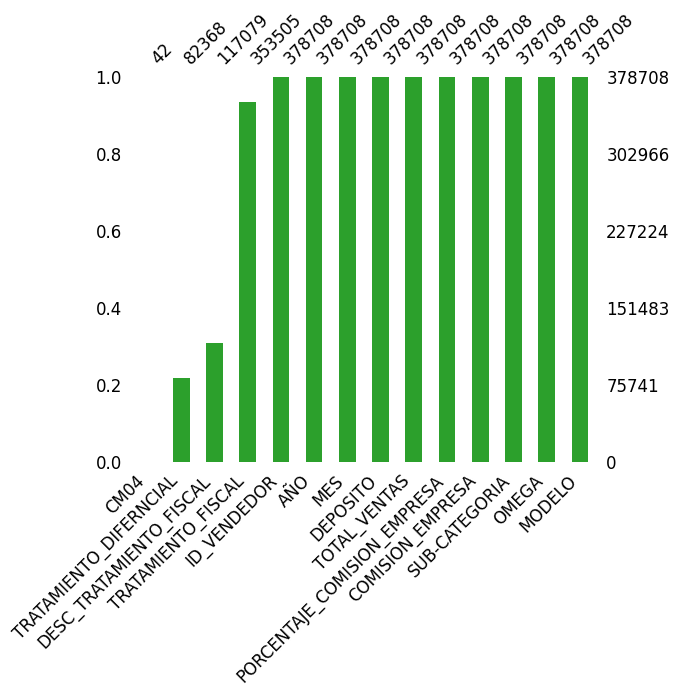

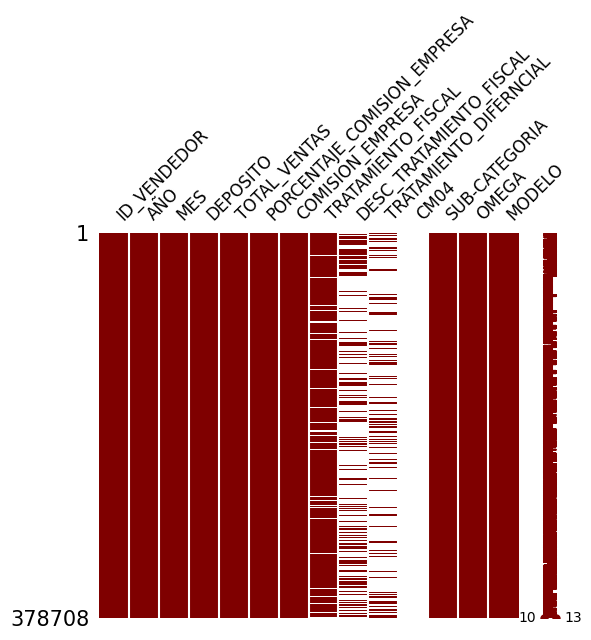

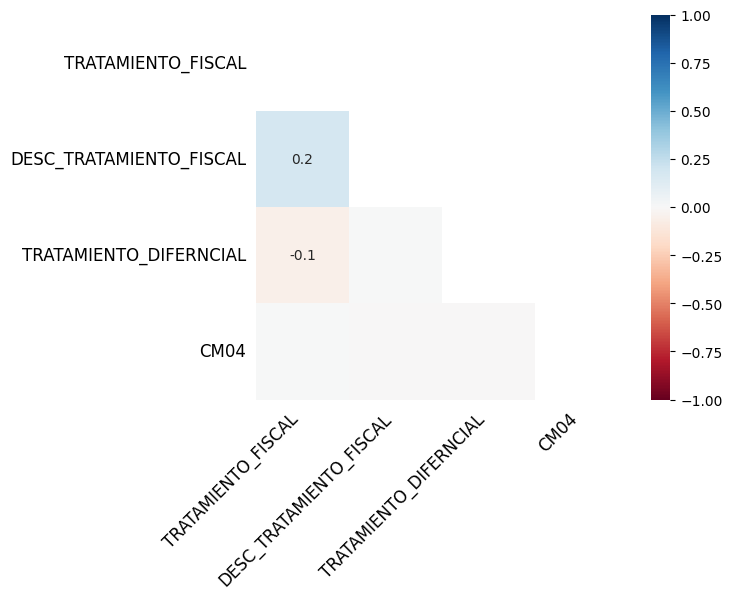

In [489]:
msno.bar(ventas_renamed.sort_values('ID_VENDEDOR'), sort="ascending", fontsize=12, color="tab:green", figsize=(6, 5))
msno.matrix(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, color=[0.5,0,0], figsize=(6, 5))
msno.heatmap(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, figsize=(6, 5))

plt.show()

In [490]:
ventas_renamed['CM04'] = ventas_renamed['CM04'].fillna('No')
ventas_renamed['TRATAMIENTO_DIFERNCIAL'] = ventas_renamed['TRATAMIENTO_DIFERNCIAL'].fillna('No')

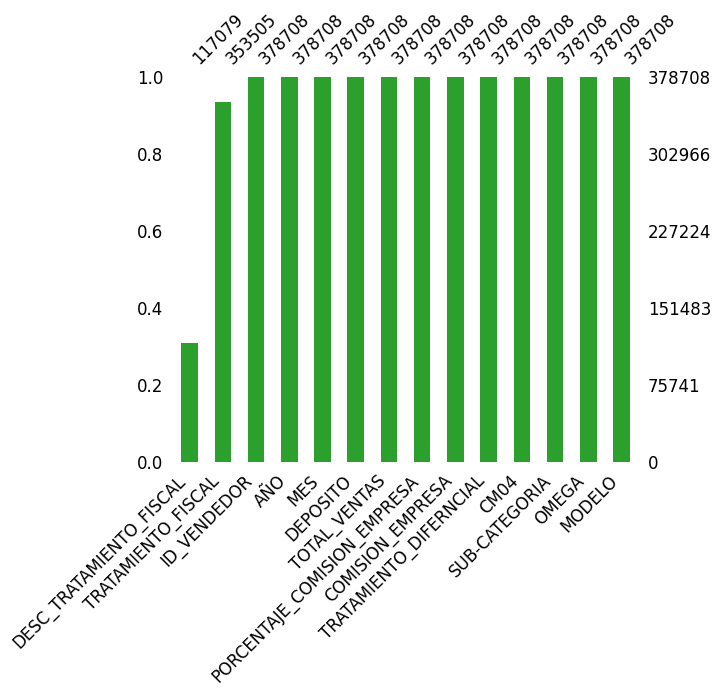

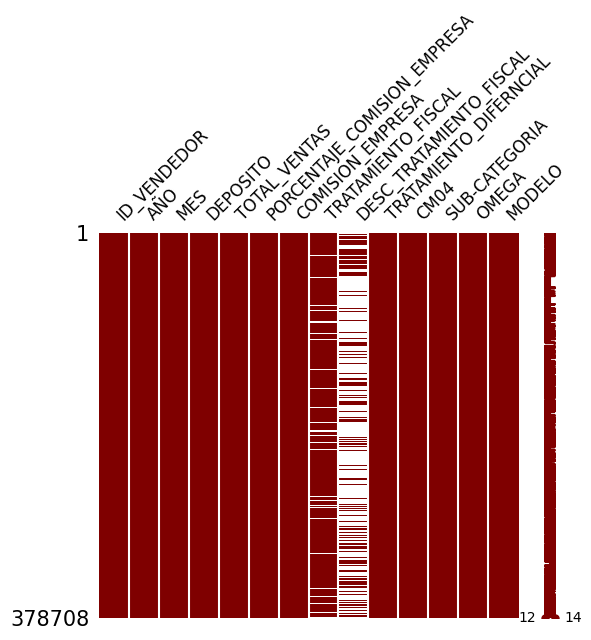

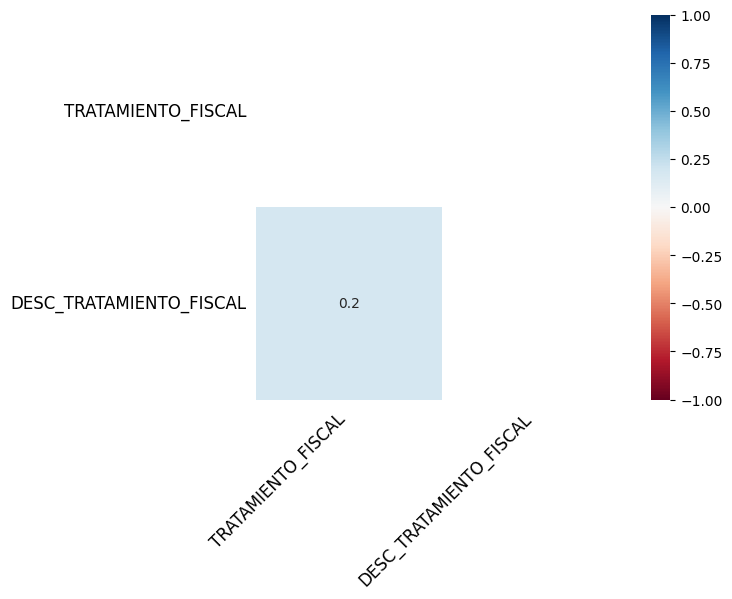

In [491]:
msno.bar(ventas_renamed.sort_values('ID_VENDEDOR'), sort="ascending", fontsize=12, color="tab:green", figsize=(6, 5))
msno.matrix(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, color=[0.5,0,0], figsize=(6, 5))
msno.heatmap(ventas_renamed.sort_values('ID_VENDEDOR'), fontsize=12, figsize=(6, 5))

plt.show()

## Anonimizado + simplificación de variables y valores
- [x] Simplificamos el nombre de las variables.
- [x] Anonimizamos la variable sensible `ID` (Paso 3).
- [x] Simplificamos (podría decir acá también que anonimizamos?) valores en `Deposito`
- [x] Unificación y simplificación de categorías de `Trat_Fisc`.
- [x] Simplificación de categorías de `Trat_Fisc_Agg` y `Trat_Dif`.
- [x] Simplificación de categorías en `Categoria`.
- [x] Guardamos todos estos diccionarios.
- [x] CM: de Si/No a 1/0.

In [492]:
# Se modifican los nombres de las columnas

# Renombramos
with open("../references/tp2_column_dict.json") as column_dict_json:
    column_dict = json.load(column_dict_json)

ventas_renamed.rename(columns = column_dict, inplace = True)
ventas_renamed.columns

Index(['ID', 'Año', 'Mes', 'Deposito', 'Ventas', 'Alicuota', 'Comision',
       'Trat_Fisc', 'Trat_Fisc_Agg', 'Trat_Dif', 'CM', 'Subrubro', 'Omega',
       'Modelo'],
      dtype='object')

In [493]:
# Anonimizamos y guardamos el diccionario para no perder esta info
ventas_hash, dict_id = anonimizar(ventas_renamed, 'ID')

with open("../references/tp2_ID_dict.json", "w") as fp:
    json.dump(dict_id, fp)

print('¡Diccionario generado!')

Actualizando variable ID
	 Progreso del 0%
	 Progreso del 10%
	 Progreso del 20%
	 Progreso del 30%
	 Progreso del 40%
	 Progreso del 50%
	 Progreso del 60%
	 Progreso del 70%
	 Progreso del 80%
	 Progreso del 90%
	 Progreso del 100%
¡Diccionario generado!


In [494]:
# Mapeo de `Deposito` a enteros
ventas_hash, dict_dep = anonimizar(ventas_hash, 'Deposito')

with open("../references/tp2_deposito_dict.json", "w") as fp:
    json.dump(dict_dep, fp)

print('¡Diccionario generado!')

Actualizando variable Deposito
	 Progreso del 0%
	 Progreso del 10%
	 Progreso del 20%
	 Progreso del 30%
	 Progreso del 40%
	 Progreso del 50%
	 Progreso del 60%
	 Progreso del 70%
	 Progreso del 80%
	 Progreso del 90%
	 Progreso del 100%
¡Diccionario generado!


In [495]:
# Mapeo de `CM` según "Si" >> 1 y "No" >> 0.
ventas_hash['CM'] = ventas_hash['CM'].replace({'No': 0, 'Si': 1})

In [496]:
# Unificacón y simplificación de categorías de `Trat_Fisc`
with open("../references/tp1_trat_fisc_dict.json") as trat_fisc_dict_json:
    trat_fisc_dict = json.load(trat_fisc_dict_json)
    
ventas_hash['Trat_Fisc'] = ventas_hash['Trat_Fisc'].astype(str)
ventas_hash['Trat_Fisc'] = ventas_hash['Trat_Fisc'].replace(trat_fisc_dict)

In [497]:
# Simplificación de categorías de `Trat_Fisc_Agg`
with open("../references/tp1_trat_fisc_agg_dict.json") as trat_fisc_agg_dict_json:
    trat_fisc_agg_dict = json.load(trat_fisc_agg_dict_json)

ventas_hash['Trat_Fisc_Agg'] = ventas_hash['Trat_Fisc_Agg'].replace(trat_fisc_agg_dict)

In [498]:
# Simplificación de categorías de `Trat_Dif`
with open("../references/tp1_trat_diff_dict.json") as trat_dif_dict_json:
    trat_dif_dict = json.load(trat_dif_dict_json)

ventas_hash['Trat_Dif'] = ventas_hash['Trat_Dif'].replace(trat_dif_dict)

In [499]:
# Simplificación de categorías de `Subrubro`
with open("../references/tp2_subrubro_dict.json") as subrubro_dict_json:
    subrubro_dict = json.load(subrubro_dict_json)

ventas_hash['Subrubro'] = ventas_hash['Subrubro'].replace(subrubro_dict)

In [500]:
ventas_hash['Subrubro'].unique()

array(['Miscelaneo', 'Venta Agrop.', 'Gondola', 'Supermercados', 'Comb.',
       'Farmacia', 'Mantenimiento', 'Com. Varios', 'Vehiculos',
       'Comb. Ley', 'Tabaco', 'Comb. Reventa'], dtype=object)

In [501]:
# Guardo todo lo hecho hasta acá, para no tener que correr todo
ventas_hash.to_csv('../data/interim/tp2_ventas_hash.csv', index=False)

## Variable fecha (Paso 6).
Creamos la variable `Fecha`, que surge como:
    $$Fecha = Año + Mes$$

Luego vamos a optar por droppear `Mes` y `Año`. Aunque para el análisis temporal habrá momentos en que necesitamos tener `Año` y `Mes` por separado, son fácilmente recuperables a través de `Fecha`.

In [502]:
ventas_hash["Fecha"] = pd.to_datetime(ventas_hash['Mes'].astype(str) + '-' + ventas_hash['Año'].astype(str), format='%m-%Y')

cols_dropear = ['Mes', 'Año']
ventas_hash = limpiar_basic(ventas_hash, cols_drop=cols_dropear)

ventas_hash[:3]

,ID,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Trat_Fisc_Agg,Trat_Dif,CM,Subrubro,Omega,Modelo,Fecha
0,0,0,14622.16,0.028,409.42,0,Norm,No,0,Miscelaneo,1,0,2019-01-01
1,1,1,62477.00,0.040,2499.08,0,Norm,No,0,Miscelaneo,1,0,2019-01-01
2,1,2,3373941.00,0.040,134957.64,0,Norm,No,0,Miscelaneo,1,0,2019-01-01


## Eliminación efecto inflación
Las variables expresadas en pesos aumentan mes a mes por efecto de la inflación. Lo que impide comparar un valor monetario de un mes contra el del mes siguiente. A fin de eliminar este efecto, una alternativa es reexpresar los valores monetarios respecto a un mes base. Por ejemplo, el último mes de la serie.

In [503]:
ventas_ipc = ventas_hash.copy()

In [504]:
# Obtener el último mes
fecha = ventas_ipc['Fecha'].max()
print(f"El último mes de la serie es el {fecha.month} de {fecha.year}")

El último mes de la serie es el 6 de 2022


El procedimiento es el siguiente:
    $$\text{VAR}_{mm-aaaa} \frac{\text{IPC}_{06-2022}}{\text{IPC}_{mm-aaaa}}$$

Para todo valor de cada variable (VAR) correspondiente a cierto mes "mm-aaaa" se lo divide por el Índice de Precios al Consumidor (IPC) correspondiente a ese mes "mm-aaaa" y luego se lo multiplica por el IPC correspondiente al mes "06-2022".

De esta forma, todos los valores de cada variable VAR van a quedar expresados en unidades monetarias del "06-2022".



Es necesario obtener de manera externa una serie del IPC que publica Indec.

In [505]:
precios = "../data/external/tp2_IPC_Indec.csv"

if exists(precios):
    print('Este archivo ya existe.')
else:
    print('Este archivo no existe: ¡Vamos a crearlo!')
    url = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_ipc_06_23.xls"
    df = pd.read_excel(url, sheet_name="Índices IPC Cobertura Nacional", header=None, usecols="B:CA", skiprows=[0, 1, 2, 3, 4, 6, 7, 8], nrows=2)
    df = df.transpose()
    df.columns = ["Fecha", "Indice"]
    df["Fecha"] = pd.to_datetime(df["Fecha"])
    df.to_csv(precios, index=False)

Este archivo ya existe.


In [506]:
# Abrir dataset de precios
precios = pd.read_csv(precios)
precios.head()

,Fecha,Indice
0,2016-12-01,100.0000
1,2017-01-01,101.5859
2,2017-02-01,103.6859
3,2017-03-01,106.1476
4,2017-04-01,108.9667


Luego debemos unir ambas bases de datos (ventas y precios), de acuerdo a la variable clave `Fecha`

In [507]:
print(ventas_ipc["Fecha"].dtype)
print(precios["Fecha"].dtype)

datetime64[ns]
object


In [508]:
# Hay que asegurar que la variable clave tenga el mismo tipo en los dos dataframes
precios["Fecha"] = pd.to_datetime(precios["Fecha"])

In [509]:
print(ventas_ipc["Fecha"].dtype)
print(precios["Fecha"].dtype)

datetime64[ns]
datetime64[ns]


In [510]:
ventas_ipc = ventas_ipc.merge(precios[["Fecha", "Indice"]], on="Fecha", how="left")
ventas_ipc.head(3)

,ID,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Trat_Fisc_Agg,Trat_Dif,CM,Subrubro,Omega,Modelo,Fecha,Indice
0,0,0,14622.16,0.028,409.42,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101
1,1,1,62477.00,0.040,2499.08,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101
2,1,2,3373941.00,0.040,134957.64,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101


La series que están expresadas en pesos son las siguientes: 
   * `Ventas`
   * `Comision`

In [511]:
# Para que las funciones se actualicen sin tener que refrescar el kernel
%load_ext autoreload
%autoreload 2
from utils_limpieza import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


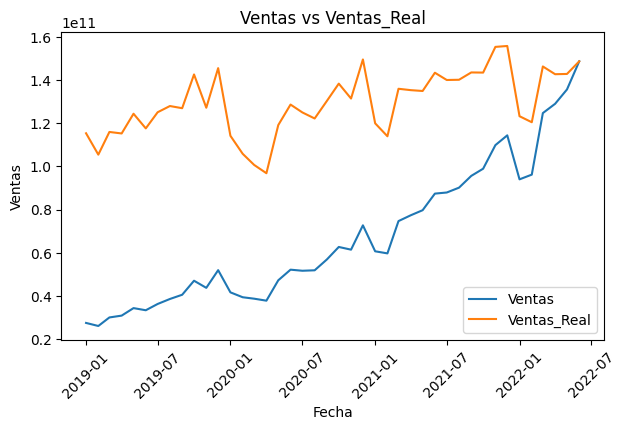

In [512]:
# Aplico la función para indexar valores respecto al último mes de la serie
indexar(ventas_ipc, 'Ventas')

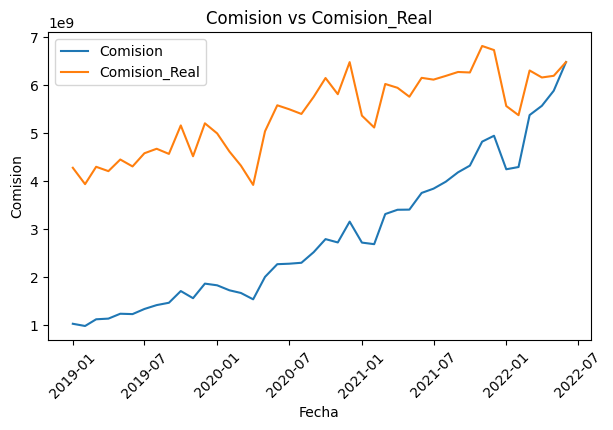

In [513]:
indexar(ventas_ipc, 'Comision')

Vemos gráficamente el efecto de la operación (por simplicidad se grafican mensualmente las series de tiempo agregando los valores por suma):

En las variantes llamadas "Reales", se observa una pendiente más moderada. El efecto de la inflación ha sido "descartado". De aquí en adelante, a la hora de hablar de los valores de estas variables, la interpretación correcta será "$ XX.XXX a precios de junio de 2022"

In [514]:
ventas_ipc.head(3)

,ID,Deposito,Ventas,Alicuota,Comision,Trat_Fisc,Trat_Fisc_Agg,Trat_Dif,CM,Subrubro,Omega,Modelo,Fecha,Indice,Ventas_Real,Comision_Real
0,0,0,14622.16,0.028,409.42,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101,6.115592e+04,1712.363645
1,1,1,62477.00,0.040,2499.08,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101,2.613046e+05,10452.185376
2,1,2,3373941.00,0.040,134957.64,0,Norm,No,0,Miscelaneo,1,0,2019-01-01,189.6101,1.411122e+07,564448.625587


In [515]:
# # Se descartan las variables que no se usan
ventas_ipc = limpiar_basic(ventas_ipc, cols_drop=['Ventas', 'Comision', 'Indice'])

# Se renombran las variables
ventas_ipc.rename(columns = {'Ventas_Real': 'Ventas', 
                             'Comision_Real': 'Comision'}, inplace = True)

# Se reacomodan las columnas
ventas_ipc = ventas_ipc[['ID', 'Omega', 'Subrubro', 'Trat_Fisc_Agg', 
                          'Trat_Fisc', 'Trat_Dif', 'CM', 
                          'Fecha','Deposito', 'Ventas', 
                          'Alicuota', 'Comision', 'Modelo']]

ventas_ipc = ventas_ipc.sort_values(['Fecha', 'Ventas']).reset_index(drop=True)

In [516]:
# Guardo todo lo hecho hasta acá, para no tener que correr todo
ventas_ipc.to_csv('../data/interim/tp2_ventas_ipc.csv', index=False)

## Análisis de variables categóricas

In [517]:
ventas_categ = ventas_ipc.drop(['Ventas', 'Alicuota', 'Comision'], axis=1).copy()
ventas_categ.head(3)

,ID,Omega,Subrubro,Trat_Fisc_Agg,Trat_Fisc,Trat_Dif,CM,Fecha,Deposito,Modelo
0,2133,1,Venta Agrop.,NaN,Norm,No,0,2019-01-01,7,0
1,1172,1,Venta Agrop.,NaN,nan,No,0,2019-01-01,7,0
2,2589,1,Vehiculos,NaN,Norm,No,0,2019-01-01,47,0


### `ID` y `Modelo`

In [518]:
checkear_unicidad(ventas_categ, 'Modelo', 'ID')

Para cada ID solo existe un valor de Modelo.


Esto implica, que si hay un vendedor que vende en más de un rubro, tiene la etiqueta de Modelo en todos los rubros.

### `Omega` y `Modelo`

En primer lugar, verificar si a cada ID único se le asigna un único valor de Omega (no debería pasar lo contrario)

In [519]:
checkear_unicidad(ventas_categ, 'Omega', 'ID')

Para cada ID solo existe un valor de Omega.


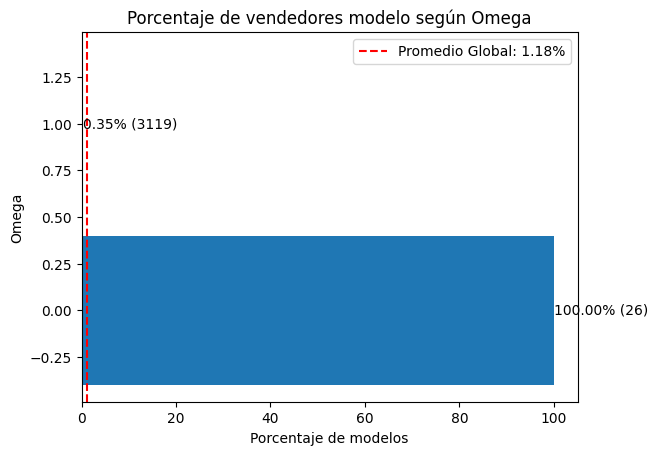

In [520]:
graficar_modelo(ventas_categ, 'Omega')

Dentro de los vendedores que son Omega (3119), solo el 0,35% es modelo.
Mientras que entre los no Omega (26), el 100% es modelo.

### `Subrubro` y `Modelo`

In [521]:
checkear_unicidad(ventas_categ, 'Subrubro', 'ID')

Para algunos ID se asignan diferentes valores de Subrubro:
ID
1992    10
1219    10
1479    10
1420     9
1530     9
        ..
1383     2
1384     2
1386     2
1390     2
3142     2
Name: Subrubro, Length: 1484, dtype: int64


En secciones previas se probó que si un ID era Modelo en un rubro, también lo era en todos.

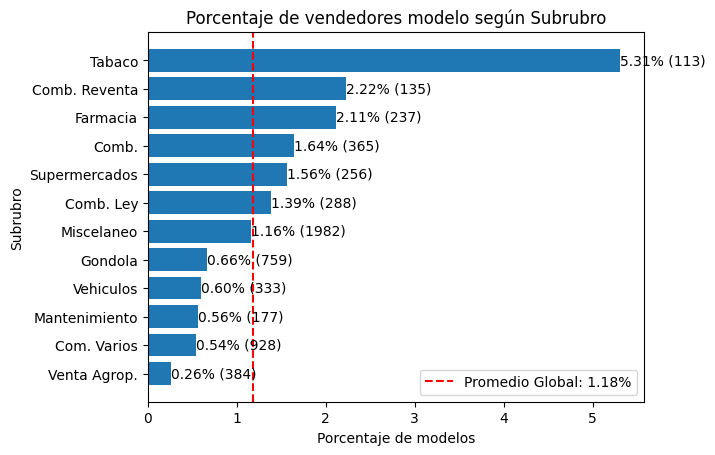

In [522]:
graficar_modelo(ventas_categ, 'Subrubro')

### `Trat_Fisc_Agg` y `Modelo`

De qué depende el tratamiento fiscal? Del cliente? Del vendedor? Del rubro? De cada venta?

In [523]:
checkear_unicidad(ventas_categ, 'Trat_Fisc_Agg', 'ID')

Para algunos ID se asignan diferentes valores de Trat_Fisc_Agg:
ID
255     3
784     3
686     3
878     3
275     3
       ..
359     2
365     2
370     2
381     2
3096    2
Name: Trat_Fisc_Agg, Length: 216, dtype: int64


Esto prueba que el atributo Trat_Fisc_Agg no es el mismo para todas las ventas de un vendedor.

Probemos si para cada vendedor, de cierto rubro, de cierto número de depósito se cumple:

In [524]:
checkear_unicidad(ventas_categ, 'Trat_Fisc_Agg', 'ID', 'Deposito','Subrubro')

Para algunos ['ID', 'Deposito', 'Subrubro'] se asignan diferentes valores de Trat_Fisc_Agg:
ID    Deposito  Subrubro   
16    21        Gondola        2
26    24        Farmacia       2
610   68        Comb. Ley      2
616   159       Miscelaneo     2
625   70        Comb.          2
                              ..
330   36        Gondola        2
341   25        Farmacia       2
349   32        Gondola        2
      36        Gondola        2
3096  72        Com. Varios    2
Name: Trat_Fisc_Agg, Length: 208, dtype: int64


Será un atributo que cambia en el tiempo?

In [525]:
checkear_unicidad(ventas_categ, 'Trat_Fisc_Agg', 'ID', 'Deposito', 'Subrubro', 'Fecha')

Para algunos ['ID', 'Deposito', 'Subrubro', 'Fecha'] se asignan diferentes valores de Trat_Fisc_Agg:
ID    Deposito  Subrubro  Fecha     
46    70        Comb.     2019-01-01    2
686   87        Tabaco    2022-06-01    2
691   70        Comb.     2019-11-01    2
                          2019-10-01    2
                          2019-09-01    2
                                       ..
275   70        Comb.     2021-09-01    2
                          2021-08-01    2
                          2021-07-01    2
                          2021-06-01    2
1027  70        Comb.     2022-06-01    2
Name: Trat_Fisc_Agg, Length: 1477, dtype: int64


Esto no contradice lo que pusimos en el data statement? Que cada renglón es una sumatoria de ventas para un mismo ID, en cierto Deposito y cierto mes?

In [526]:
#Un caso:
ventas_categ[(ventas_categ['ID'] == 691) & (ventas_categ['Deposito'] == 70) & (ventas_categ['Subrubro'] == 'Comb.') & (ventas_categ['Fecha'] == '2019-11-01')]

,ID,Omega,Subrubro,Trat_Fisc_Agg,Trat_Fisc,Trat_Dif,CM,Fecha,Deposito,Modelo
89569,691,1,Comb.,Norm,0,Art.19+20,0,2019-11-01,70,0
91321,691,1,Comb.,Otro,3,Art.19+20,0,2019-11-01,70,0


De cualquier manera, esto hace pensar que el tratamiento fiscal depende del cliente o de la venta en particular y no del vendedor.

##### Checkear con `Ventas` si hay cierto punto de corte para entrar por ej desde exento a normal y luego a otro

In [527]:
ventas_prueba = ventas_ipc[['ID', 'Deposito', 'Subrubro', 'Fecha','Ventas','Trat_Fisc_Agg']].dropna(subset=['Trat_Fisc_Agg']).copy()
duplicados = ventas_prueba[ventas_prueba.duplicated(subset=['ID', 'Deposito', 'Subrubro', 'Fecha'], keep=False)].sort_values(by=['ID', 'Deposito', 'Subrubro', 'Fecha'], ascending=True).copy()
duplicados

,ID,Deposito,Subrubro,Fecha,Ventas,Trat_Fisc_Agg
4075,46,70,Comb.,2019-01-01,3.260466e+05,Norm
7011,46,70,Comb.,2019-01-01,1.307356e+07,Otro
12683,46,70,Comb.,2019-02-01,3.239680e+05,Norm
15539,46,70,Comb.,2019-02-01,1.208608e+07,Otro
21220,46,70,Comb.,2019-03-01,3.767316e+05,Norm
...,...,...,...,...,...,...
359077,1027,70,Comb.,2022-04-01,4.387913e+07,Otro
364842,1027,70,Comb.,2022-05-01,5.513953e+05,Norm
368617,1027,70,Comb.,2022-05-01,4.625576e+07,Otro
374369,1027,70,Comb.,2022-06-01,6.333820e+05,Norm


In [528]:
duplicados.groupby('Trat_Fisc_Agg')['Ventas'].mean()

Trat_Fisc_Agg
Exento    5.259615e+06
Norm      7.558465e+06
Otro      3.483398e+07
Name: Ventas, dtype: float64

En promedio, se cumple que "Exento" es menor a "Norm", que a su vez es menor a "Otro". Veamos si se cumple en todos los casos:

Si resultado es True, significa que, dentro de cada grupo, el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 'Exento' siempre es menor que el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 'Normal', y ambos son menores que el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 'Otro'. Si resultado es False, significa que al menos en un grupo no se cumple esta condición.

In [529]:
resultado = duplicados.groupby(['ID', 'Deposito', 'Subrubro', 'Fecha']).apply(lambda x: x[x['Trat_Fisc_Agg'] == 'Exento']['Ventas'].max() < x[x['Trat_Fisc_Agg'] == 'Norm']['Ventas'].min() < x[x['Trat_Fisc_Agg'] == 'Otro']['Ventas'].min()).all()
resultado

False

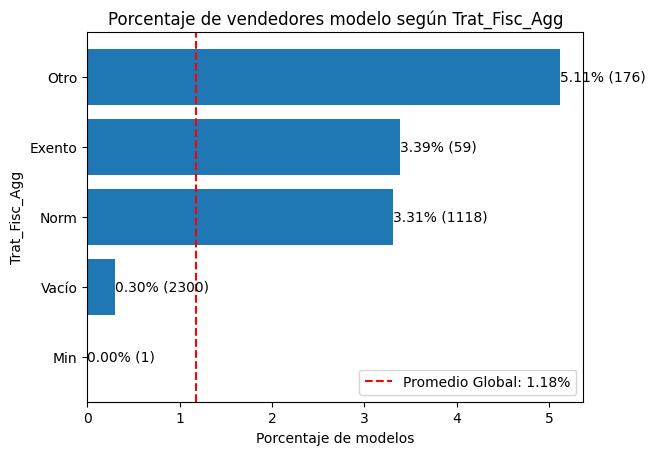

In [530]:
graficar_modelo(ventas_categ, 'Trat_Fisc_Agg')

### `Trat_Fisc` y `Modelo`

In [531]:
checkear_unicidad(ventas_categ, 'Trat_Fisc', 'ID', 'Deposito', 'Subrubro', 'Fecha')

Para algunos ['ID', 'Deposito', 'Subrubro', 'Fecha'] se asignan diferentes valores de Trat_Fisc:
ID    Deposito  Subrubro    Fecha     
2145  9         Miscelaneo  2019-01-01    8
2910  46        Vehiculos   2019-02-01    7
2770  17        Farmacia    2021-09-01    7
2910  46        Vehiculos   2020-02-01    6
                            2019-01-01    6
                                         ..
1381  50        Miscelaneo  2021-05-01    2
                            2021-06-01    2
                            2021-07-01    2
                            2021-08-01    2
3075  31        Farmacia    2020-05-01    2
Name: Trat_Fisc, Length: 12667, dtype: int64


##### Checkear con `Ventas` si hay cierto punto de corte para pasar de una a otra categoría

In [532]:
ventas_prueba = ventas_ipc[['ID', 'Deposito', 'Subrubro', 'Fecha','Ventas','Trat_Fisc']].dropna(subset=['Trat_Fisc']).copy()
duplicados = ventas_prueba[ventas_prueba.duplicated(subset=['ID', 'Deposito', 'Subrubro', 'Fecha'], keep=False)].sort_values(by=['ID', 'Deposito', 'Subrubro', 'Fecha'], ascending=True).copy()
duplicados.groupby('Trat_Fisc')['Ventas'].mean()

Trat_Fisc
0                    8.946478e+06
1                    5.259615e+06
3                    3.460052e+07
Alícuota agravada    4.525596e+07
Alícuota reducida    1.308655e+07
Esp.1                1.070293e+08
Esp.2                8.177575e+07
Esp.3                6.895990e+07
Esp.4                2.298493e+08
Exento               3.671295e+07
MeraComp             7.119958e+07
Min                  5.382834e+06
Norm                 2.465215e+06
nan                  3.572062e+07
Name: Ventas, dtype: float64

Probamos con un caso.

Si resultado es True, significa que, dentro de cada grupo, el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 0 siempre es mayor que el valor de 'Ventas' correspondiente a 'Trat_Fisc_Agg' == 1. Si resultado es False, significa que al menos en un grupo no se cumple esta condición.

In [533]:
resultado = duplicados.groupby(['ID', 'Deposito', 'Subrubro', 'Fecha']).apply(lambda x: x[x['Trat_Fisc'] == 0]['Ventas'].max() > x[x['Trat_Fisc'] == 1]['Ventas'].min()).all()
resultado

False

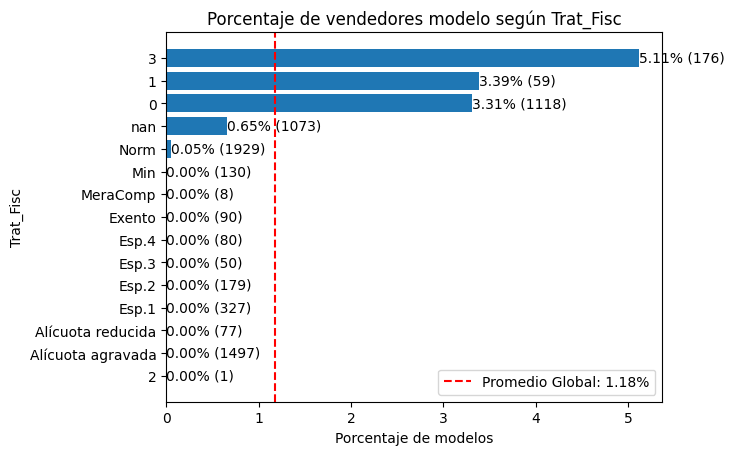

In [534]:
graficar_modelo(ventas_categ, 'Trat_Fisc')

### `Trat_Dif` y `Modelo`

In [535]:
checkear_unicidad(ventas_categ, 'Trat_Dif', 'ID', 'Deposito', 'Subrubro', 'Fecha')

Para cada ['ID', 'Deposito', 'Subrubro', 'Fecha'] solo existe un valor de Trat_Dif.


In [536]:
checkear_unicidad(ventas_categ, 'Trat_Dif', 'ID', 'Deposito', 'Subrubro')

Para algunos ['ID', 'Deposito', 'Subrubro'] se asignan diferentes valores de Trat_Dif:
ID    Deposito  Subrubro     
4     6         Gondola          2
1683  68        Comb. Ley        2
1682  36        Gondola          2
1672  17        Farmacia         2
1669  24        Farmacia         2
                                ..
824   106       Comb. Reventa    2
      70        Comb.            2
      68        Comb. Ley        2
      67        Comb. Ley        2
2978  92        Com. Varios      2
Name: Trat_Dif, Length: 1704, dtype: int64


Se debe a que `Trat_Dif` cambia en el tiempo? O a que hay pocos casos con valores?

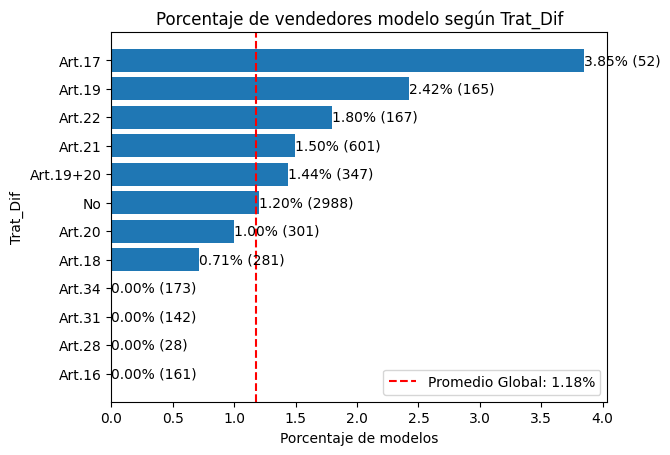

In [537]:
graficar_modelo(ventas_categ, 'Trat_Dif')

### `CM` y `Modelo` (Paso 4)

In [538]:
checkear_unicidad(ventas_categ, 'CM', 'ID')

Para cada ID solo existe un valor de CM.


In [539]:
casos_unicos_cm_1 = ventas_categ[ventas_categ['CM'] == 1]['ID'].nunique()
print("Número de casos únicos de ID para CM = 1:", casos_unicos_cm_1)

Número de casos únicos de ID para CM = 1: 1


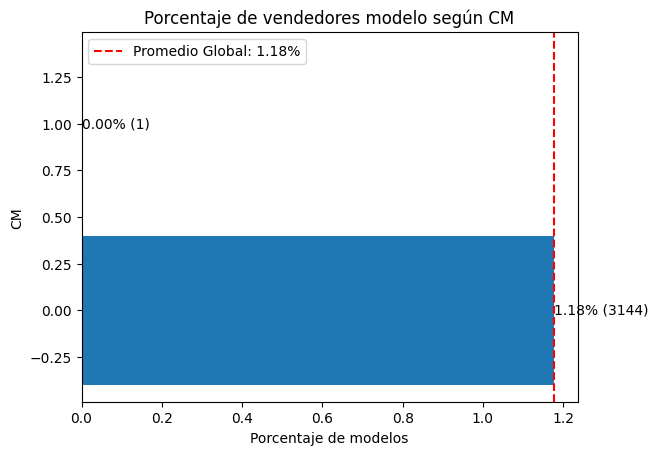

In [540]:
graficar_modelo(ventas_categ, 'CM')

Solo hay un caso que está bajo CM igual a 1 (y no es vendedor modelo). El tamaño de muestra equivale al 0,01% de los casos.

In [541]:
print(f"{round(len(ventas_categ[ventas_categ['CM'] == 1]) / len(ventas_categ) * 100, 2)}%")

0.01%


Se procederá a descartar el caso en un dataset aparte. Y se eliminará la variable `CM`.

In [542]:
#Eliminación de caso CM=1 y columna CM. Y almacenamiento en un dataset aparte

# Se opera sobre el dataset completo

ventas_cm = ventas_ipc[ventas_ipc['CM'] == 1].copy()
ventas_cm.to_csv('../data/interim/tp2_ventas_cm.csv')

ventas_ipc = ventas_ipc[ventas_ipc['CM'] != 1].copy()
ventas_ipc = limpiar_basic(ventas_ipc, 'CM')

# Y luego sobre el dataset de variables categóricas

ventas_categ = ventas_categ[ventas_categ['CM'] != 1].copy()
ventas_categ = limpiar_basic(ventas_categ, 'CM')
ventas_categ

,ID,Omega,Subrubro,Trat_Fisc_Agg,Trat_Fisc,Trat_Dif,Fecha,Deposito,Modelo
0,2133,1,Venta Agrop.,NaN,Norm,No,2019-01-01,7,0
1,1172,1,Venta Agrop.,NaN,nan,No,2019-01-01,7,0
2,2589,1,Vehiculos,NaN,Norm,No,2019-01-01,47,0
3,1907,1,Venta Agrop.,NaN,Norm,No,2019-01-01,5,0
4,1478,1,Venta Agrop.,NaN,nan,No,2019-01-01,7,0
...,...,...,...,...,...,...,...,...,...
378703,815,1,Supermercados,Norm,0,No,2022-06-01,8,0
378704,1098,1,Supermercados,NaN,Alícuota agravada,No,2022-06-01,130,0
378705,1091,1,Supermercados,NaN,Alícuota agravada,No,2022-06-01,130,0
378706,2862,1,Venta Agrop.,NaN,Alícuota agravada,No,2022-06-01,5,0


### Relación entre variables fiscales (`Trat_Fisc` y `Trat_Fisc_Agg` y `Trat_Dif`) (Paso 5)

#### `Trat_Fisc` y `Trat_Fisc_Agg`

Queremos chequear para qué valores de `Trat_Fisc` aparecen valores de `Trat_Fisc_Agg`.

In [543]:
# Este paso lo agrego porque sino el crosstab siguiente no me muestra los NaN
ventas_categ['Trat_Fisc'] = ventas_categ['Trat_Fisc'].fillna('Warning: Relleno')
ventas_categ['Trat_Fisc_Agg'] = ventas_categ['Trat_Fisc_Agg'].fillna('Warning: Relleno')

pd.crosstab(ventas_categ['Trat_Fisc'], ventas_categ['Trat_Fisc_Agg'], dropna=False)

Trat_Fisc_Agg,Exento,Min,Norm,Otro,Warning: Relleno
Trat_Fisc,,,,,
0,0,0,110158,0,0
1,769,0,0,0,0
2,0,1,0,0,0
3,0,0,0,6151,0
Alícuota agravada,0,0,0,0,76566
Alícuota reducida,0,0,0,0,913
Esp.1,0,0,0,0,5383
Esp.2,0,0,0,0,4162
Esp.3,0,0,0,0,621


Al analizar la tabla de contingencia, vemos que los valores de `Trat_Fisc_Agg` sólo aparecen cuando `Trat_Fisc` asume valores 0, 1, 2 ó 3. 
A su vez, hay correspondencia entre 0 y Norm, 1 y Exento, 2 y Min, 3 y Otro. 
¿Se puede unificar todo como `Trat_Fisc`, eliminando entonces `Trat_Fisc_Agg`? ¿Tiene sentido que falte la descripción asociada al tratamiento?

<Axes: xlabel='Trat_Fisc_Agg', ylabel='Trat_Fisc'>

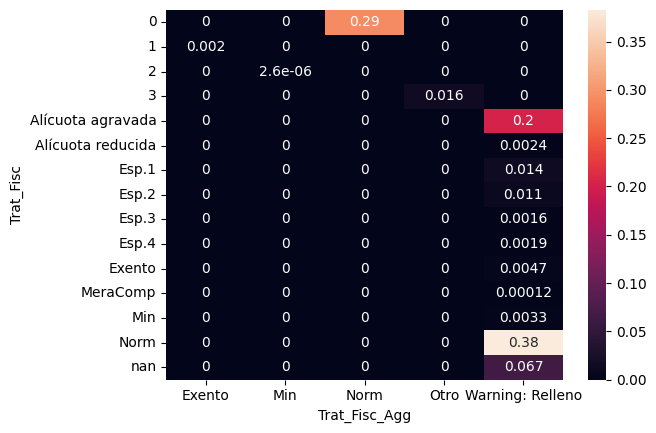

In [544]:
vad = pd.crosstab(ventas_categ['Trat_Fisc'].fillna("Warning: NA"), ventas_categ['Trat_Fisc_Agg'].fillna("Warning: NA"), normalize=True)
sns.heatmap(vad, annot=True)

Vemos que sí existe una gran correlación entre "Norm" de `Trat_Fisc_Agg` y "0" de `Trat_Fisc`.

#### Relación entre `Trat_Fisc` y `Trat_Dif`

Ahora veamos para qué valores de `Trat_Fisc` aparecen valores de `Trat_Dif`. Al analizar la tabla de contingencia vemos que no hay un patrón claro. ¿Podríamos tomar a un dato faltante como "sin tratamiento" o algo por el estilo?

In [545]:
# Este paso lo agrego porque sino el crosstab siguiente no me muestra los NaN
ventas_categ['Trat_Dif'] = ventas_categ['Trat_Dif'].fillna('Waring: Relleno')

pd.crosstab(ventas_categ['Trat_Fisc'], ventas_categ['Trat_Dif'], dropna=False)

Trat_Dif,Art.16,Art.17,Art.18,Art.19,Art.19+20,Art.20,Art.21,Art.22,Art.28,Art.31,Art.34,No
Trat_Fisc,,,,,,,,,,,,
0,813,266,1250,1120,2434,3136,7689,412,167,726,1948,90197
1,0,0,15,48,0,14,162,0,0,1,2,527
2,0,0,0,0,0,0,0,0,0,0,0,1
3,0,119,25,560,1078,80,3220,731,0,2,1,335
Alícuota agravada,608,12,181,62,81,2706,1770,1025,0,56,667,69398
Alícuota reducida,249,0,17,0,9,36,75,1,0,0,36,490
Esp.1,106,81,313,258,185,1087,983,750,74,2,5,1539
Esp.2,1,0,54,0,75,330,1901,1793,0,0,0,8
Esp.3,5,0,13,0,0,551,2,2,0,0,0,48


*   Se concluye que la variable que más información aporta es la de `Trat_Fisc`, superando a `Trat_Fisc_Agg` en que tiene menos valores perdidos. Y a su vez, la información de `Trat_Fisc_Agg` (Exento, Min, Norm, Otro), es capturada por los valores 1, 2, 0, 3 de `Trat_Fisc_Agg`, respectivamente.


*   Respecto a `Trat_Diff`, la misma es superada por `Trat_Fisc` en cuanto a ausencia de valores perdidos. La variable `Trat_Fisc`, en el práctico anterior, había permitido detectar ciertas tendencias de ventas. A su vez que no queda claro el aporte de `Trat_Diff`.


La decisión es droppear `Trat_Fisc_Agg` y `Trat_Dif`

In [546]:
# Se opera sobre el dataset completo
ventas_ipc = limpiar_basic(ventas_ipc, ['Trat_Fisc_Agg', 'Trat_Dif'])

# Y luego sobre el dataset de variables categóricas
ventas_categ = limpiar_basic(ventas_categ, ['Trat_Fisc_Agg', 'Trat_Dif'])
ventas_categ


,ID,Omega,Subrubro,Trat_Fisc,Fecha,Deposito,Modelo
0,2133,1,Venta Agrop.,Norm,2019-01-01,7,0
1,1172,1,Venta Agrop.,nan,2019-01-01,7,0
2,2589,1,Vehiculos,Norm,2019-01-01,47,0
3,1907,1,Venta Agrop.,Norm,2019-01-01,5,0
4,1478,1,Venta Agrop.,nan,2019-01-01,7,0
...,...,...,...,...,...,...,...
378703,815,1,Supermercados,0,2022-06-01,8,0
378704,1098,1,Supermercados,Alícuota agravada,2022-06-01,130,0
378705,1091,1,Supermercados,Alícuota agravada,2022-06-01,130,0
378706,2862,1,Venta Agrop.,Alícuota agravada,2022-06-01,5,0


In [548]:
ventas_ipc.to_csv('../data/interim/tp2_ventas_ipc.csv')
ventas_ipc

,ID,Omega,Subrubro,Trat_Fisc,Fecha,Deposito,Ventas,Alicuota,Comision,Modelo
0,2133,1,Venta Agrop.,Norm,2019-01-01,7,-1.116697e+07,2.00,-2.233394e+05,0
1,1172,1,Venta Agrop.,nan,2019-01-01,7,-5.494877e+06,2.40,-1.318771e+05,0
2,2589,1,Vehiculos,Norm,2019-01-01,47,-2.331939e+06,4.00,-9.327756e+04,0
3,1907,1,Venta Agrop.,Norm,2019-01-01,5,-1.131988e+06,2.00,-2.263974e+04,0
4,1478,1,Venta Agrop.,nan,2019-01-01,7,-4.177637e+05,2.40,-1.002633e+04,0
...,...,...,...,...,...,...,...,...,...,...
378703,815,1,Supermercados,0,2022-06-01,8,1.567422e+09,0.05,7.837112e+07,0
378704,1098,1,Supermercados,Alícuota agravada,2022-06-01,130,1.732460e+09,5.00,8.662302e+07,0
378705,1091,1,Supermercados,Alícuota agravada,2022-06-01,130,2.240194e+09,5.00,1.120097e+08,0
378706,2862,1,Venta Agrop.,Alícuota agravada,2022-06-01,5,2.631098e+09,3.00,7.893293e+07,0
